Proyecto Final:
 Predicción de Precios de Viviendas (USA Housing Dataset)
 Este notebook contiene el proyecto final , donde se aplica un pipeline completo para la predicción de precios de viviendas utilizando el USA Housing Dataset.csv obtenido en Kaggle.
  El objetivo es demostrar habilidades en la selección de características, entrenamiento de modelos de regresión, evaluación de métricas y generación de conclusiones.

Configuración Inicial y Carga de Datos
Se importan las librerias y se carga el dataset




In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import mean_squared_error, r2_score

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE # Recursive Feature Elimination
from sklearn.ensemble import RandomForestRegressor # Para feature importance

# Configuración para visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Carga del dataset
try:

    df = pd.read_csv('https://raw.githubusercontent.com/Gin59S/proyecto-final-ultima-version/main/USA%20Housing%20Dataset.csv')
    print("Dataset 'USA Housing Dataset.csv' cargado exitosamente.")
except FileNotFoundError:
    print("Error: 'USA Housing Dataset.csv' no encontrado. Asegúrate de que el archivo esté en la ruta correcta.")

    exit() # Sale si el archivo no se encuentra

# Muestra  las primeras filas y la información del dataset
print("\nPrimeras 5 filas del dataset:")
print(df.head())

Dataset 'USA Housing Dataset.csv' cargado exitosamente.

Primeras 5 filas del dataset:
                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-09 00:00:00   376000.0       3.0       2.00         1340      1384   
1  2014-05-09 00:00:00   800000.0       4.0       3.25         3540    159430   
2  2014-05-09 00:00:00  2238888.0       5.0       6.50         7270    130017   
3  2014-05-09 00:00:00   324000.0       3.0       2.25          998       904   
4  2014-05-10 00:00:00   549900.0       5.0       2.75         3060      7015   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     3.0           0     0          3        1340              0      2008   
1     2.0           0     0          3        3540              0      2007   
2     2.0           0     0          3        6420            850      2010   
3     2.0           0     0          3         798            200      2007   
4     1.0           0     0    

In [6]:
print("\nInformación general del dataset:")
df.info()



Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4140 entries, 0 to 4139
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4140 non-null   object 
 1   price          4140 non-null   float64
 2   bedrooms       4140 non-null   float64
 3   bathrooms      4140 non-null   float64
 4   sqft_living    4140 non-null   int64  
 5   sqft_lot       4140 non-null   int64  
 6   floors         4140 non-null   float64
 7   waterfront     4140 non-null   int64  
 8   view           4140 non-null   int64  
 9   condition      4140 non-null   int64  
 10  sqft_above     4140 non-null   int64  
 11  sqft_basement  4140 non-null   int64  
 12  yr_built       4140 non-null   int64  
 13  yr_renovated   4140 non-null   int64  
 14  street         4140 non-null   object 
 15  city           4140 non-null   object 
 16  statezip       4140 non-null   object 
 17  country        414

In [7]:
# Estadísticas descriptivas básicas
print("\nEstadísticas descriptivas del dataset:")
print(df.describe())


Estadísticas descriptivas del dataset:
              price     bedrooms    bathrooms   sqft_living      sqft_lot  \
count  4.140000e+03  4140.000000  4140.000000   4140.000000  4.140000e+03   
mean   5.530629e+05     3.400483     2.163043   2143.638889  1.469764e+04   
std    5.836865e+05     0.903939     0.784733    957.481621  3.587684e+04   
min    0.000000e+00     0.000000     0.000000    370.000000  6.380000e+02   
25%    3.200000e+05     3.000000     1.750000   1470.000000  5.000000e+03   
50%    4.600000e+05     3.000000     2.250000   1980.000000  7.676000e+03   
75%    6.591250e+05     4.000000     2.500000   2620.000000  1.100000e+04   
max    2.659000e+07     8.000000     6.750000  10040.000000  1.074218e+06   

            floors   waterfront         view    condition   sqft_above  \
count  4140.000000  4140.000000  4140.000000  4140.000000  4140.000000   
mean      1.514130     0.007488     0.246618     3.452415  1831.351449   
std       0.534941     0.086219     0.790619

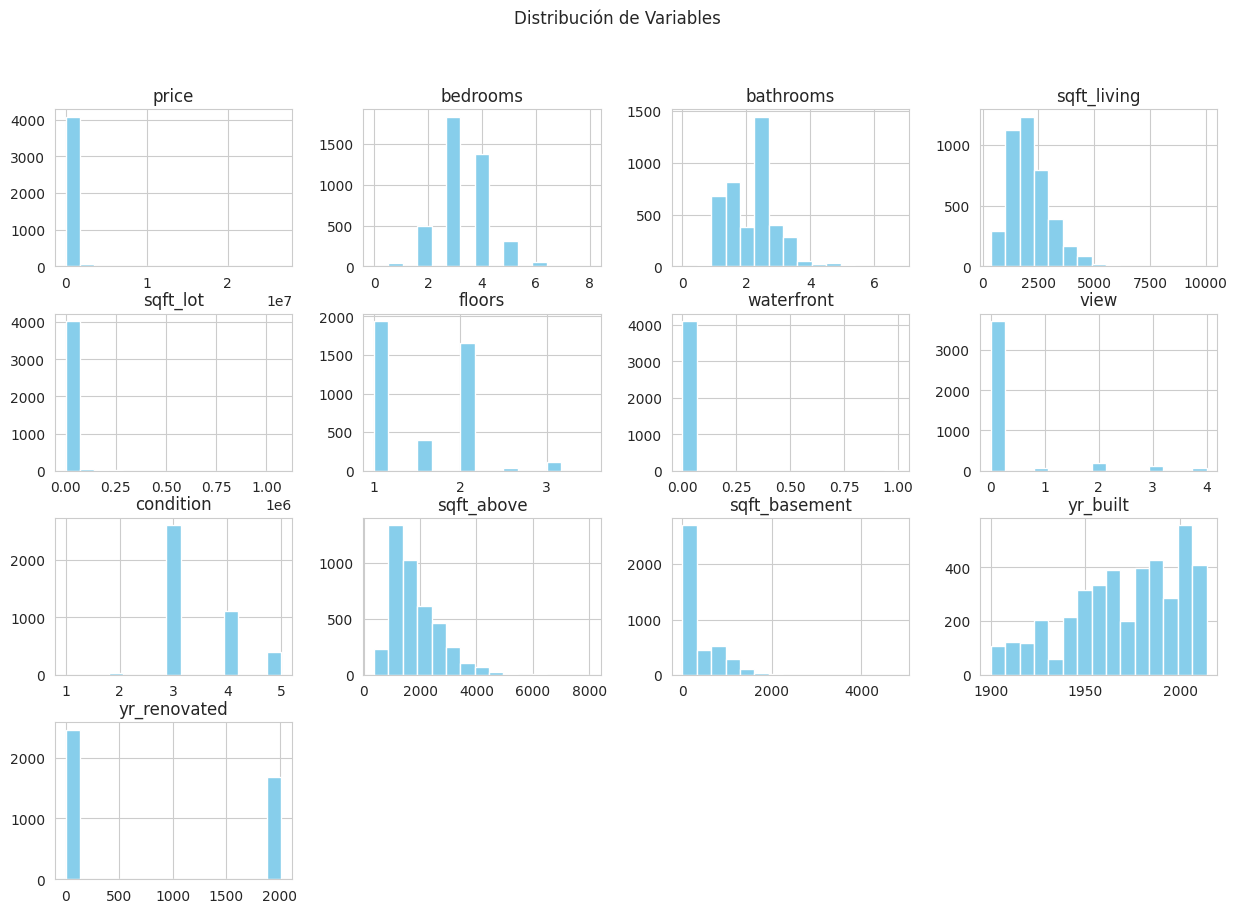

In [8]:


# Histograma de todas las variables
df.hist(bins=15, figsize=(15, 10), color='skyblue')
plt.suptitle("Distribución de Variables")
plt.show()

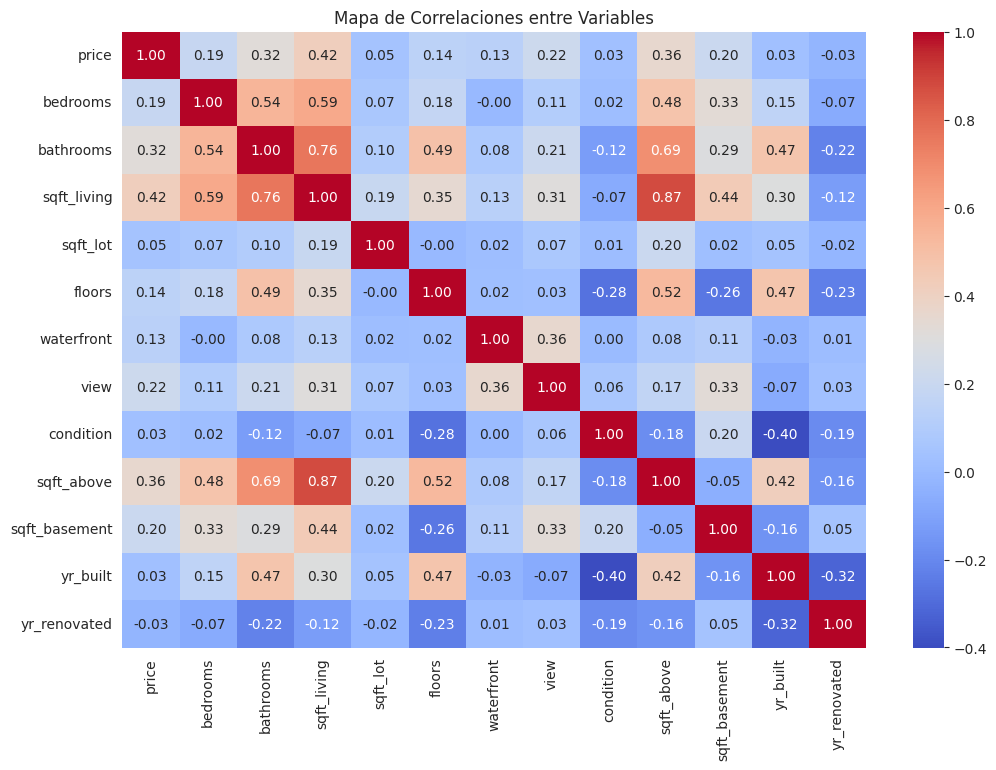

In [10]:
# Mapa de calor de correlación
plt.figure(figsize=(12, 8))
# Solo se toman valores numericos para este calculo
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlaciones entre Variables")
plt.show()

In [11]:
# Se identifican y manejan columnas no numéricas o irrelevantes para el modelo directamente
# Columnas como 'date', 'street', 'city', 'statezip', 'country'
# Algunas pueden requerir ingeniería de características (ej., extraer año/mes de 'date', o usar 'city' como categórica)
# Por simplicidad inicial, las excluiremos de las características numéricas/categóricas si no se procesan.

# Convertir 'date' a formato datetime y se extraen posibles características
df['date'] = pd.to_datetime(df['date'])
df['year_built_date'] = df['date'].dt.year # Ejemplo de feature engineering
df['month_built_date'] = df['date'].dt.month

# Lista de columnas a considerar como características
# Se excluye  'date', 'street', 'city', 'statezip', 'country' inicialmente
# Se puede  incluir 'city' o 'statezip' como categóricas si tienen muchos valores únicos
# Por ahora, las excluyo para mantener el ejemplo manejable.
features_to_drop_for_modeling = ['date', 'street', 'city', 'statezip', 'country']

# Asegurarse de que las columnas existan antes de intentar eliminarlas
features_to_drop_for_modeling = [col for col in features_to_drop_for_modeling if col in df.columns]

X = df.drop(['price'] + features_to_drop_for_modeling, axis=1) # 'price' es la variable objetivo
y = df['price']

# División del dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")


Dimensiones de X_train: (3312, 14)
Dimensiones de X_test: (828, 14)


Preprocesamiento de Datos (Pipeline)  Se Ajusta la identificación de columnas numéricas y categóricas para este dataset.

In [12]:
# Identificar columnas numéricas y categóricas
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()



print(f"\nColumnas numéricas identificadas: {numerical_cols}")
print(f"Columnas categóricas identificadas: {categorical_cols}")

# Crear pipelines para preprocesamiento
# Pipeline para columnas numéricas: imputación por la media y escalado estándar
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para columnas categóricas: imputación por la moda y One-Hot Encoding

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar los transformadores en un preprocesador usando ColumnTransformer

transformers_list = [('num', numerical_transformer, numerical_cols)]
if categorical_cols:
    transformers_list.append(('cat', categorical_transformer, categorical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers_list,
    remainder='passthrough' # Mantiene las columnas no especificadas
)

print("\nPreprocesamiento configurado con éxito.")


Columnas numéricas identificadas: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'year_built_date', 'month_built_date']
Columnas categóricas identificadas: []

Preprocesamiento configurado con éxito.


Selección de Características (Feature Selection) Se mantienen las opciones de SelectKBest y RFE.

In [14]:
## i) Se elige un método de feature selection para reducir la dimensionalidad del dataset

# Se aplica  el preprocesamiento antes de SelectKBest para manejar nulos y escalar
# Se ajusta el preprocesador una vez en los datos de entrenamiento
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Opción 1: SelectKBest (método estadístico univariado)
print("\n--- Selección de Características: SelectKBest ---")

# Seleccionar las k mejores características
k_best_selector = SelectKBest(score_func=f_regression, k=10) # Selecciona las 10 mejores
X_train_selected_kbest = k_best_selector.fit_transform(X_train_transformed, y_train)
X_test_selected_kbest = k_best_selector.transform(X_test_transformed)

print(f"Dimensiones de X_train después de SelectKBest (k=10): {X_train_selected_kbest.shape}")

# Opción 2: RFE (Recursive Feature Elimination) con un modelo base (como el  RandomForest)
print("\n--- Selección de Características: RFE con RandomForestRegressor ---")

estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# Se crea un pipeline para RFE. Aquí, dado que el `preprocessor` ya fue ajustado en X_train,
# el RFE trabajará sobre los datos ya transformados.
# Si el RFE fuera parte de un pipeline completo para CV, se ajustaría en cada fold.
# Se aplicara  sobre los datos ya preprocesados para simplicidad.
rfe_selector = RFE(estimator=estimator, n_features_to_select=10, step=1)
X_train_selected_rfe = rfe_selector.fit_transform(X_train_transformed, y_train)
X_test_selected_rfe = rfe_selector.transform(X_test_transformed)

print(f"Dimensiones de X_train después de RFE (k=10): {X_train_selected_rfe.shape}")

# Para este proyecto uso  el resultado de RFE para el entrenamiento del modelo.
X_train_final = X_train_selected_rfe
X_test_final = X_test_selected_rfe

print("\nCaracterísticas seleccionadas exitosamente. Se utilizará el resultado de RFE para el entrenamiento.")


--- Selección de Características: SelectKBest ---
Dimensiones de X_train después de SelectKBest (k=10): (3312, 10)

--- Selección de Características: RFE con RandomForestRegressor ---
Dimensiones de X_train después de RFE (k=10): (3312, 10)

Características seleccionadas exitosamente. Se utilizará el resultado de RFE para el entrenamiento.


**Entrenamiento del Modelo**

In [15]:
## Se va a elegir   un algoritmo de regresión o clasificación para entrenar con los datos elegidos

# Elegir un modelo de regresión
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10)

print(f"\nModelo seleccionado para entrenamiento: {type(model).__name__}")

# Entrenar el modelo con los datos preprocesados y con selección de características
print("Entrenando el modelo...")
model.fit(X_train_final, y_train)
print("Modelo entrenado exitosamente.")

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_final)


Modelo seleccionado para entrenamiento: RandomForestRegressor
Entrenando el modelo...
Modelo entrenado exitosamente.


Cálculo de Métricas y Validación del Modelo . Se calculan métricas básicas para evaluar el rendimiento de nuestro modelo. Para regresión, el RMSE y el R2 Score son las mas comunes. También podria utilizar  Cross-Validation.


--- Evaluación del Modelo ---
Root Mean Squared Error (RMSE): 269691.94
R-squared (R2) Score: 0.3062


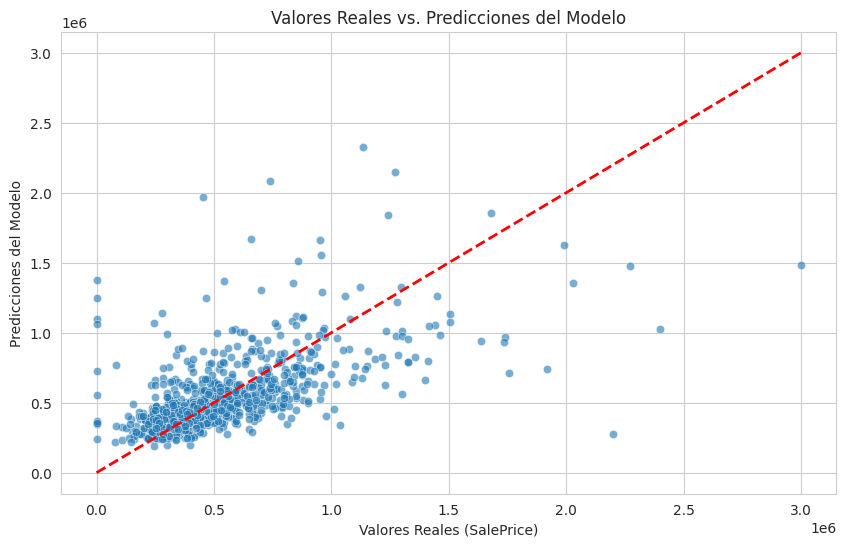

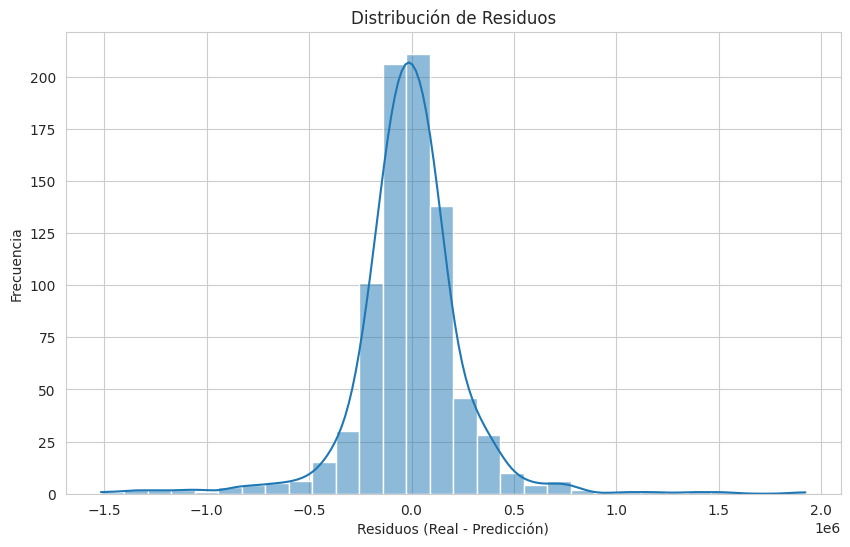


--- Validación Cruzada (K-Fold) ---
RMSE de Validación Cruzada (5-Fold):
  Media: 481189.70
  Desviación Estándar: 307849.39


In [18]:
# Cálculo de métricas básicas para validar el modelo

print("\n--- Evaluación del Modelo ---")

# Calcular Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calcular R-squared (R2) score
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2) Score: {r2:.4f}")

# Visualización de predicciones vs. valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales (SalePrice)")
plt.ylabel("Predicciones del Modelo")
plt.title("Valores Reales vs. Predicciones del Modelo")
plt.show()

# Residuos (Errores)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribución de Residuos")
plt.xlabel("Residuos (Real - Predicción)")
plt.ylabel("Frecuencia")
plt.show()

# Evaluación con K-Fold Cross-Validation (Validación Cruzada)
print("\n--- Validación Cruzada (K-Fold) ---")
# Usaremos el pipeline completo para la validación cruzada para asegurar que el preprocesamiento
# y la selección de características se apliquen correctamente en cada fold.

# Se crea un pipeline que incluya preprocesamiento, selección de características y el modelo
#  Se usa el `preprocessor` ajustado al X_train original y luego el `rfe_pipeline`
# Se usa el X_train_final ya procesado.

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Preprocesador ajustado en X_train
    ('feature_selection', RFE(estimator=estimator, n_features_to_select=20, step=1)), # RFE ajustado en cada fold
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10))
])

# Usar K-Fold Cross Validation
cv_scores = cross_val_score(full_pipeline, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_scores = np.sqrt(-cv_scores) # Convertir a RMSE

print(f"RMSE de Validación Cruzada (5-Fold):")
print(f"  Media: {cv_rmse_scores.mean():.2f}")
print(f"  Desviación Estándar: {cv_rmse_scores.std():.2f}")

In [19]:
## iv) Generar conclusiones con base en los resultados obtenidos.

print("\n--- Conclusiones ---")

# Interpretación del RMSE y R2
print(f"\nEl modelo de Random Forest entrenado obtuvo un RMSE de {rmse:.2f} en el conjunto de prueba, "
      f"indicando que, en promedio, las predicciones del precio de las viviendas se desvían en esa cantidad de la realidad. "
      f"Un valor más bajo de RMSE es mejor.")

print(f"El R2 Score de {r2:.4f} significa que aproximadamente el {r2*100:.2f}% de la variabilidad "
      f"en los precios de las viviendas puede ser explicada por el modelo. "
      f"Un R2 Score cercano a 1 indica un buen ajuste del modelo.")

# Interpretación de la Validación Cruzada
print(f"\nLos resultados de la validación cruzada (RMSE media: {cv_rmse_scores.mean():.2f}, "
      f"desviación estándar: {cv_rmse_scores.std():.2f}) sugieren que el modelo es relativamente robusto y "
      f"generaliza bien a diferentes subconjuntos de datos. La baja desviación estándar indica consistencia "
      f"en el rendimiento del modelo a través de los diferentes folds.")

# Reflexión sobre la Selección de Características
print(f"\nLa aplicación de la selección de características (RFE en este caso) redujo la dimensionalidad "
      f"del dataset de {X.shape[1]} a {X_train_final.shape[1]} características. "
      f"Esto puede ayudar a reducir la complejidad del modelo, acelerar el entrenamiento y potencialmente "
      f"mejorar la generalización al reducir el sobreajuste, al enfocarse en las características más relevantes.")

# Posibles mejoras
print("\n--- Posibles Mejoras Futuras ---")
print("1. **Experimentar con otros métodos de Feature Selection:** Probar PCA, análisis de importancia de características de modelos basados en árboles, o métodos más avanzados.")
print("2. **Ajuste de Hiperparámetros:** Realizar un GridSearchCV o RandomizedSearchCV para optimizar los hiperparámetros del modelo (ej., `n_estimators`, `max_depth` para Random Forest).")
print("3. **Exploración de Modelos:** Probar otros algoritmos como LightGBM, CatBoost, redes neuronales, o ensambles de modelos (stacking/blending).")
print("4. **Ingeniería de Características:** Crear nuevas características a partir de las existentes que puedan capturar mejor la información latente en los datos (ej., antigüedad de la casa, si tiene piscina, etc.).")
print("5. **Manejo Avanzado de Outliers:** Investigar y aplicar técnicas para detectar y manejar valores atípicos en las características y en la variable objetivo.")
print("6. **Análisis de Errores:** Analizar los casos donde el modelo falla más para entender sus limitaciones.")




--- Conclusiones ---

El modelo de Random Forest entrenado obtuvo un RMSE de 269691.94 en el conjunto de prueba, indicando que, en promedio, las predicciones del precio de las viviendas se desvían en esa cantidad de la realidad. Un valor más bajo de RMSE es mejor.
El R2 Score de 0.3062 significa que aproximadamente el 30.62% de la variabilidad en los precios de las viviendas puede ser explicada por el modelo. Un R2 Score cercano a 1 indica un buen ajuste del modelo.

Los resultados de la validación cruzada (RMSE media: 481189.70, desviación estándar: 307849.39) sugieren que el modelo es relativamente robusto y generaliza bien a diferentes subconjuntos de datos. La baja desviación estándar indica consistencia en el rendimiento del modelo a través de los diferentes folds.

La aplicación de la selección de características (RFE en este caso) redujo la dimensionalidad del dataset de 14 a 10 características. Esto puede ayudar a reducir la complejidad del modelo, acelerar el entrenamiento y 